# Illegal wildlife Trade: Urgent Global Problem

### Data Scientist Expectation : Expert user of algorithms, Capable of wrangling data, story telling, communication and presentation


##### 3 Tasks

####  Task 1 : Supervised learning model - Predict high risk customers
###### mulitple data sources, feature engineering, customer networks, very imbalanced : 2% positive

####  Task 2 : Finding IWT(Illegal Wildlife Trade) networks - wild-life trafficking patterns from the provided data
###### methods to detect IWT networks, data & graph analysis, Text analysis on transaction messages

#### Task 3 : Entity extraction and resolution - Crawling news webpages for finding known wild-life traffickers and matching with provided customers.
###### efficiently crawl web pages, match names with data (~300k customers), Find reported bad actors in customer networks, Find suspicious counterparties for reported bad actors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
sns.set()

#### Data overview

#### Transactions: Cash, Wire, EMT

#### Customer: Name, Age, Tenure, Occupation

#### External: News webpages, government websites, etc.


In [3]:
wire_trxms = pd.read_csv('wire_trxns.csv')
emt_trxms = pd.read_csv('emt_trxns.csv')
cash_trxms = pd.read_csv('cash_trxns.csv')
kyc = pd.read_csv('kyc.csv')

In [4]:
wire_trxms.head(1)

,id sender,id receiver,name sender,name receiver,wire value,country sender,country receiver,trxn_id
0,EXTERNAL753550,CUST30139466,CHEN MIN,DESTINY MOORE,10098.0,CN,CA,TKEV83070517


In [5]:
emt_trxms.head(1)

,id sender,id receiver,name sender,name receiver,emt message,emt value,trxn_id
0,CUST26232205,CUST94681618,JASON GARRISON,RENEE LANG,for the bike u lent me,154.0,WFEZ76031047


In [6]:
cash_trxms.head(1)

,cust_id,amount,type,trxn_id
0,CUST69827909,2330,deposit,XFMC87396884


In [7]:
kyc.head(1)

,Name,Gender,Occupation,Age,Tenure,cust_id,label
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0


In [8]:
print(wire_trxms.shape , emt_trxms.shape, cash_trxms.shape, kyc.shape)

(67872, 8) (506451, 7) (212532, 4) (195789, 7)


In [9]:
cash_trxms.groupby('type').count()

,cust_id,amount,trxn_id
type,,,
deposit,116710,116710,116710
withdrawal,95822,95822,95822


## Aggregation at customer ID  ~ Type - Sender / Withdrawal level

In [10]:
def agg_emt_metrics_sender(kyc:pd.DataFrame, emt_trxns:pd.DataFrame):

    kyc_emt_joined = kyc.merge(emt_trxms, left_on='cust_id', right_on='id sender', how='left')

    aggregated_metrics = kyc_emt_joined.groupby('cust_id').agg(
        emt_msg_count_s=('emt message', lambda x: x.notnull().sum()),
        emt_trxn_count_s=('trxn_id', 'count'),
        sum_emt_trxn_s=('emt value', 'sum'),
        var_emt_trxn_s=('emt value', lambda x: x.var() if len(x) > 1 else 0),  
        count_emt_greater_than_mean_s=('emt value', lambda x: (x > x.mean()).sum()),
        emt_rec_ext_ratio_s=('id receiver', lambda x: (x.str.startswith('EXTERNAL').sum()) / x.nunique() if x.nunique() > 0 else 0)
    ).reset_index()

    kyc_with_aggregates = kyc.merge(aggregated_metrics, on='cust_id', how='left')

    return kyc_with_aggregates

In [11]:
kyc_emt_sender = agg_emt_metrics_sender(kyc, emt_trxms)
kyc_emt_sender

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,emt_trxn_count_s,sum_emt_trxn_s,var_emt_trxn_s,count_emt_greater_than_mean_s,emt_rec_ext_ratio_s
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,7,14412.0,2.967649e+06,4,0.428571
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,0,0.0,0.000000e+00,0,0.000000
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,1,5,4494.0,2.375915e+06,1,0.200000
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,0.000000e+00,0,0.000000
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,5,1147.5,4.754425e+04,2,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,0,3,789.5,1.615083e+03,2,0.333333
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,0,0,0.0,0.000000e+00,0,0.000000
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,0,8,4720.0,3.102400e+05,4,0.000000
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,0,0.0,0.000000e+00,0,0.000000


In [12]:
def agg_wr_metrics_sender(kyc_emt_sender: pd.DataFrame, wire_trxms: pd.DataFrame):
    one_hot_countries = pd.get_dummies(wire_trxms['country receiver'], prefix='country')
    wire_trxms_encoded = pd.concat([wire_trxms, one_hot_countries], axis=1)

    one_hot_aggregated = wire_trxms_encoded.groupby('id sender')[one_hot_countries.columns].sum().reset_index()

    aggregated_metrics = wire_trxms.groupby('id sender').agg(
        wr_trxn_count_s=('trxn_id', 'count'),
        sum_wr_trxn_s=('wire value', 'sum'),
        var_wr_trxn_s=('wire value', lambda x: x.var() if len(x) > 1 else 0),
        count_wr_greater_than_mean_s=('wire value', lambda x: (x > x.mean()).sum()),
        wr_rec_ext_ratio_s=('id receiver', lambda x: (x.str.startswith('EXTERNAL').sum()) / x.nunique() if x.nunique() > 0 else 0),
        wr_country_count_s=('country receiver', 'nunique')
    ).reset_index()

    aggregated_with_one_hot = pd.merge(aggregated_metrics, one_hot_aggregated, on='id sender', how='left')

    kyc_with_aggregates = kyc_emt_sender.merge(aggregated_with_one_hot, left_on='cust_id', right_on='id sender', how='left')

    return kyc_with_aggregates


In [13]:
kyc_emt_wr_sender = agg_wr_metrics_sender(kyc_emt_sender, wire_trxms)
kyc_emt_wr_sender

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,emt_trxn_count_s,sum_emt_trxn_s,...,country_AU,country_CA,country_CN,country_GE,country_IN,country_MX,country_RU,country_SA,country_UK,country_US
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,7,14412.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,1,5,4494.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,5,1147.5,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,0,3,789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,0,8,4720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
def agg_csh_metrics_sender(kyc_emt_wr_sender: pd.DataFrame, cash_trxms: pd.DataFrame):

    csh_withd = cash_trxms[cash_trxms['type'] == 'withdrawal']

    total_sum_transactions = cash_trxms.groupby('cust_id')['amount'].sum().rename('total_sum_transactions')

    aggregated_metrics_withd = csh_withd.groupby('cust_id').agg(
        withd_trxn_count=('trxn_id', 'count'),
        sum_csh_withd=('amount', 'sum'),
        var_csh_withd=('amount', lambda x: x.var() if len(x) > 1 else 0),  
        count_cshWithd_greater_than_mean=('amount', lambda x: (x > x.mean()).sum())
    ).reset_index()

    aggregated_metrics_withd = aggregated_metrics_withd.merge(total_sum_transactions, on='cust_id', how='left')

    aggregated_metrics_withd['ratio_sum_csh_withd_to_total'] = aggregated_metrics_withd['sum_csh_withd'] / aggregated_metrics_withd['total_sum_transactions']

    kyc_with_aggregates = kyc_emt_wr_sender.merge(aggregated_metrics_withd, on='cust_id', how='left')

    return kyc_with_aggregates


In [15]:
kyc_sender_all = agg_csh_metrics_sender(kyc_emt_wr_sender, cash_trxms)
kyc_sender_all

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,emt_trxn_count_s,sum_emt_trxn_s,...,country_RU,country_SA,country_UK,country_US,withd_trxn_count,sum_csh_withd,var_csh_withd,count_cshWithd_greater_than_mean,total_sum_transactions,ratio_sum_csh_withd_to_total
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,7,14412.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,1,5,4494.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,...,NaN,NaN,NaN,NaN,2.0,650.0,28800.0,1.0,650.0,1.000000
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,5,1147.5,...,0.0,0.0,0.0,0.0,2.0,19585.0,159612.5,1.0,87700.0,0.223318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,0,3,789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,0,8,4720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,8465.0,0.0,0.0,14730.0,0.574678


## Aggregation at customer ID  ~ Type - Receiver / Deposit level

In [16]:
def agg_emt_metrics_receiver(kyc:pd.DataFrame, emt_trxns:pd.DataFrame):

    kyc_emt_joined = kyc.merge(emt_trxms, left_on='cust_id', right_on='id receiver', how='left')

    aggregated_metrics = kyc_emt_joined.groupby('cust_id').agg(
        emt_msg_count_r=('emt message', lambda x: x.notnull().sum()),
        emt_trxn_count_r=('trxn_id', 'count'),
        sum_emt_trxn_r=('emt value', 'sum'),
        var_emt_trxn_r=('emt value', lambda x: x.var() if len(x) > 1 else 0),  
        count_emt_greater_than_mean_r=('emt value', lambda x: (x > x.mean()).sum()),
        emt_send_ext_ratio_r=('id sender', lambda x: (x.str.startswith('EXTERNAL').sum()) / x.nunique() if x.nunique() > 0 else 0)
    ).reset_index()

    kyc_with_aggregates = kyc.merge(aggregated_metrics, on='cust_id', how='left')

    return kyc_with_aggregates

In [17]:
kyc_emt_receiver = agg_emt_metrics_receiver(kyc, emt_trxms)
kyc_emt_receiver

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_r,emt_trxn_count_r,sum_emt_trxn_r,var_emt_trxn_r,count_emt_greater_than_mean_r,emt_send_ext_ratio_r
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,8,11484.5,2.815567e+06,2,0.250000
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,1,84.0,0.000000e+00,0,1.000000
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,0,13,6538.5,3.047159e+05,3,0.500000
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,0.000000e+00,0,0.000000
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,8,18289.0,8.565787e+06,4,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,2,13,3280.5,2.674697e+04,8,0.461538
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,1,2,656.0,1.872720e+05,1,1.000000
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,1,7,3347.5,2.184224e+05,3,0.428571
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,1,44.0,0.000000e+00,0,1.000000


In [18]:
def agg_wr_metrics_receiver(kyc_emt_receiver: pd.DataFrame, wire_trxms: pd.DataFrame):
    one_hot_countries = pd.get_dummies(wire_trxms['country sender'], prefix='country')
    wire_trxms_encoded = pd.concat([wire_trxms, one_hot_countries], axis=1)

    one_hot_aggregated = wire_trxms_encoded.groupby('id receiver')[one_hot_countries.columns].sum().reset_index()

    aggregated_metrics = wire_trxms.groupby('id receiver').agg(
        wr_trxn_count_r=('trxn_id', 'count'),
        sum_wr_trxn_r=('wire value', 'sum'),
        var_wr_trxn_r=('wire value', lambda x: x.var() if len(x) > 1 else 0),  
        count_wr_greater_than_mean_r=('wire value', lambda x: (x > x.mean()).sum()),
        wr_send_ext_ratio_r=('id sender', lambda x: (x.str.startswith('EXTERNAL').sum()) / x.nunique() if x.nunique() > 0 else 0),
        wr_country_count_r=('country sender', 'nunique')
    ).reset_index()

    aggregated_with_one_hot = pd.merge(aggregated_metrics, one_hot_aggregated, on='id receiver', how='left')

    kyc_with_aggregates = kyc_emt_receiver.merge(aggregated_with_one_hot, left_on='cust_id', right_on='id receiver', how='left')

    return kyc_with_aggregates

In [19]:
kyc_emt_wr_receiver = agg_wr_metrics_receiver(kyc_emt_receiver, wire_trxms)
kyc_emt_wr_receiver

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_r,emt_trxn_count_r,sum_emt_trxn_r,...,country_AU,country_CA,country_CN,country_GE,country_IN,country_MX,country_RU,country_SA,country_UK,country_US
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,8,11484.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,1,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,0,13,6538.5,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,8,18289.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,2,13,3280.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,1,2,656.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,1,7,3347.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,1,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def agg_csh_metrics_receiver(kyc_emt_wr_receiver: pd.DataFrame, cash_trxms: pd.DataFrame):

    csh_deposit = cash_trxms[cash_trxms['type'] == 'deposit']

    total_sum_transactions = cash_trxms.groupby('cust_id')['amount'].sum().rename('total_sum_transactions')

    aggregated_metrics_withd = csh_deposit.groupby('cust_id').agg(
        dep_trxn_count=('trxn_id', 'count'),
        sum_csh_dep=('amount', 'sum'),
        var_csh_dep=('amount', lambda x: x.var() if len(x) > 1 else 0),  
        count_cshDep_greater_than_mean=('amount', lambda x: (x > x.mean()).sum())
    ).reset_index()

    aggregated_metrics_withd = aggregated_metrics_withd.merge(total_sum_transactions, on='cust_id', how='left')

    aggregated_metrics_withd['ratio_sum_csh_dep_to_total'] = aggregated_metrics_withd['sum_csh_dep'] / aggregated_metrics_withd['total_sum_transactions']

    kyc_with_aggregates = kyc_emt_wr_receiver.merge(aggregated_metrics_withd, on='cust_id', how='left')

    return kyc_with_aggregates


In [21]:
kyc_receiver_all = agg_csh_metrics_receiver(kyc_emt_wr_receiver, cash_trxms)
kyc_receiver_all

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_r,emt_trxn_count_r,sum_emt_trxn_r,...,country_RU,country_SA,country_UK,country_US,dep_trxn_count,sum_csh_dep,var_csh_dep,count_cshDep_greater_than_mean,total_sum_transactions,ratio_sum_csh_dep_to_total
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,8,11484.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,1,84.0,...,NaN,NaN,NaN,NaN,1.0,1210.0,0.0,0.0,1210.0,1.000000
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,0,13,6538.5,...,0.0,0.0,0.0,0.0,2.0,3835.0,49612.5,1.0,3835.0,1.000000
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,8,18289.0,...,0.0,0.0,0.0,0.0,9.0,68115.0,7592475.0,3.0,87700.0,0.776682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,2,13,3280.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,1,2,656.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,1,7,3347.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,1,44.0,...,NaN,NaN,NaN,NaN,2.0,6265.0,632812.5,1.0,14730.0,0.425322


In [22]:
temp_merge = kyc_sender_all.merge(kyc_receiver_all, how = 'outer', on = ['Name', 'Gender', 'Occupation', 'Age', 'Tenure', 'cust_id', 'label'])
temp_merge

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,emt_trxn_count_s,sum_emt_trxn_s,...,country_RU_y,country_SA_y,country_UK_y,country_US_y,dep_trxn_count,sum_csh_dep,var_csh_dep,count_cshDep_greater_than_mean,total_sum_transactions_y,ratio_sum_csh_dep_to_total
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,7,14412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANTHONY ADAMS,male,Musician,52.0,8.0,CUST69248708,0,0,0,0.0,...,NaN,NaN,NaN,NaN,1.0,1210.0,0.0,0.0,1210.0,1.000000
2,DENISE LEWIS,female,Jewelry Dealer,43.0,11.0,CUST67222818,0,1,5,4494.0,...,0.0,0.0,0.0,0.0,2.0,3835.0,49612.5,1.0,3835.0,1.000000
3,STEPHEN FIGUEROA,male,Optometrist,35.0,17.0,CUST33995820,0,0,0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,KYLE EDWARDS,male,Real Estate Broker,39.0,21.0,CUST76401392,1,0,5,1147.5,...,0.0,0.0,0.0,0.0,9.0,68115.0,7592475.0,3.0,87700.0,0.776682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195784,THOMAS YOUNG,male,Software Developer,46.0,3.0,CUST23014082,0,0,3,789.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195785,CASEY JONES,male,Miner,31.0,10.0,CUST17691251,0,0,0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
195786,NICOLE-CÉCILE LEBLANC,female,Unknown,21.0,3.0,CUST26444112,0,0,8,4720.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
195787,CATHERINE ARMSTRONG,female,Antiques Dealer,58.0,14.0,CUST96567835,0,0,0,0.0,...,NaN,NaN,NaN,NaN,2.0,6265.0,632812.5,1.0,14730.0,0.425322


In [23]:
temp_merge.columns

Index(['Name', 'Gender', 'Occupation', 'Age', 'Tenure', 'cust_id', 'label',
       'emt_msg_count_s', 'emt_trxn_count_s', 'sum_emt_trxn_s',
       'var_emt_trxn_s', 'count_emt_greater_than_mean_s',
       'emt_rec_ext_ratio_s', 'id sender', 'wr_trxn_count_s', 'sum_wr_trxn_s',
       'var_wr_trxn_s', 'count_wr_greater_than_mean_s', 'wr_rec_ext_ratio_s',
       'wr_country_count_s', 'country_AU_x', 'country_CA_x', 'country_CN_x',
       'country_GE_x', 'country_IN_x', 'country_MX_x', 'country_RU_x',
       'country_SA_x', 'country_UK_x', 'country_US_x', 'withd_trxn_count',
       'sum_csh_withd', 'var_csh_withd', 'count_cshWithd_greater_than_mean',
       'total_sum_transactions_x', 'ratio_sum_csh_withd_to_total',
       'emt_msg_count_r', 'emt_trxn_count_r', 'sum_emt_trxn_r',
       'var_emt_trxn_r', 'count_emt_greater_than_mean_r',
       'emt_send_ext_ratio_r', 'id receiver', 'wr_trxn_count_r',
       'sum_wr_trxn_r', 'var_wr_trxn_r', 'count_wr_greater_than_mean_r',
       'wr_send_ex

In [24]:
temp_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195789 entries, 0 to 195788
Data columns (total 65 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Name                              195789 non-null  object 
 1   Gender                            195789 non-null  object 
 2   Occupation                        195789 non-null  object 
 3   Age                               195789 non-null  float64
 4   Tenure                            195789 non-null  float64
 5   cust_id                           195789 non-null  object 
 6   label                             195789 non-null  int64  
 7   emt_msg_count_s                   195789 non-null  int64  
 8   emt_trxn_count_s                  195789 non-null  int64  
 9   sum_emt_trxn_s                    195789 non-null  float64
 10  var_emt_trxn_s                    195789 non-null  float64
 11  count_emt_greater_than_mean_s     195789 non-null  i

temp_merge.to_csv('all_data.csv')

df = temp_merge.dropna(subset=["emt_trxn_count_s","wr_trxn_count_s","withd_trxn_count",
                               "emt_trxn_count_r","wr_trxn_count_r"], inplace=True)

In [25]:
df = temp_merge.fillna(0)

In [26]:
df.head(1)

,Name,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,emt_trxn_count_s,sum_emt_trxn_s,...,country_RU_y,country_SA_y,country_UK_y,country_US_y,dep_trxn_count,sum_csh_dep,var_csh_dep,count_cshDep_greater_than_mean,total_sum_transactions_y,ratio_sum_csh_dep_to_total
0,JENNIFER WELLS,female,Architect,45.0,13.0,CUST82758793,0,0,7,14412.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_upd = df.copy()

In [28]:
cols_to_drop = ['emt_trxn_count_s','wr_trxn_count_s','emt_trxn_count_r','total_sum_transactions_y',
                'count_emt_greater_than_mean_s','count_wr_greater_than_mean_s','count_cshDep_greater_than_mean'
                ,'count_cshWithd_greater_than_mean','count_emt_greater_than_mean_r','wr_trxn_count_r'
                ,'count_wr_greater_than_mean_r','withd_trxn_count','dep_trxn_count','country_AU_x',
                'country_CA_x', 'country_CN_x', 'country_GE_x', 'country_IN_x', 'country_MX_x',
                'country_RU_x', 'country_SA_x', 'country_UK_x', 'country_US_x','country_AU_y',
                'country_CA_y', 'country_CN_y', 'country_GE_y', 'country_IN_y', 'country_MX_y',
                'country_RU_y', 'country_SA_y', 'country_UK_y','country_US_y',
                'var_emt_trxn_s','var_wr_trxn_s','var_csh_withd','var_emt_trxn_r','var_wr_trxn_r','var_csh_dep',
                'total_sum_transactions_x','wr_country_count_r','wr_country_count_s','Name','id sender']
df_upd.drop(cols_to_drop,inplace = True, axis =1)

<ipython-input-29-40c77760e192>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_upd.corr(), annot=False, fmt=".2f", cmap='coolwarm')


<Axes: >

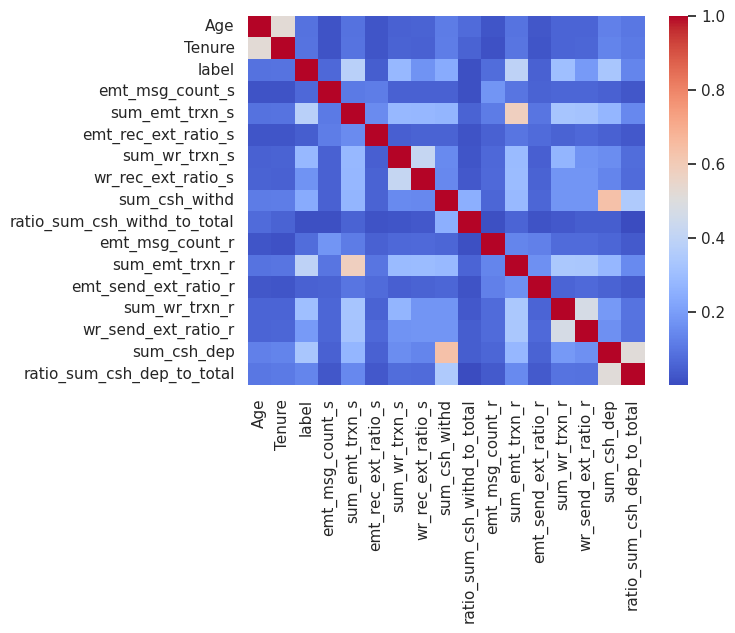

In [29]:
sns.heatmap(df_upd.corr(), annot=False, fmt=".2f", cmap='coolwarm')

In [30]:
df_upd.columns

Index(['Gender', 'Occupation', 'Age', 'Tenure', 'cust_id', 'label',
       'emt_msg_count_s', 'sum_emt_trxn_s', 'emt_rec_ext_ratio_s',
       'sum_wr_trxn_s', 'wr_rec_ext_ratio_s', 'sum_csh_withd',
       'ratio_sum_csh_withd_to_total', 'emt_msg_count_r', 'sum_emt_trxn_r',
       'emt_send_ext_ratio_r', 'id receiver', 'sum_wr_trxn_r',
       'wr_send_ext_ratio_r', 'sum_csh_dep', 'ratio_sum_csh_dep_to_total'],
      dtype='object')

In [31]:
df_upd.head(1)

,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,sum_emt_trxn_s,emt_rec_ext_ratio_s,sum_wr_trxn_s,...,sum_csh_withd,ratio_sum_csh_withd_to_total,emt_msg_count_r,sum_emt_trxn_r,emt_send_ext_ratio_r,id receiver,sum_wr_trxn_r,wr_send_ext_ratio_r,sum_csh_dep,ratio_sum_csh_dep_to_total
0,female,Architect,45.0,13.0,CUST82758793,0,0,14412.0,0.428571,3971.5,...,0.0,0.0,0,11484.5,0.25,0,0.0,0.0,0.0,0.0


In [32]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_upd['Gender'] = label_encoder.fit_transform(df_upd['Gender'])
df_upd.head(1)

,Gender,Occupation,Age,Tenure,cust_id,label,emt_msg_count_s,sum_emt_trxn_s,emt_rec_ext_ratio_s,sum_wr_trxn_s,...,sum_csh_withd,ratio_sum_csh_withd_to_total,emt_msg_count_r,sum_emt_trxn_r,emt_send_ext_ratio_r,id receiver,sum_wr_trxn_r,wr_send_ext_ratio_r,sum_csh_dep,ratio_sum_csh_dep_to_total
0,0,Architect,45.0,13.0,CUST82758793,0,0,14412.0,0.428571,3971.5,...,0.0,0.0,0,11484.5,0.25,0,0.0,0.0,0.0,0.0


In [33]:
final_df_up_2 = df_upd.copy()

## For Testing

In [34]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor

#Getting numerical columns
#numerical_final_df = df_upd.select_dtypes(include=['float64', 'int64'])
#Making a copy
#X = numerical_final_df.copy()

#vif_data = pd.DataFrame()
#vif_data["feature"] = X.columns

# calculating VIF for each feature
#vif_data["VIF"] = [variance_inflation_factor(X.values, i)
 #                         for i in range(len(X.columns))]

#vif_data

In [35]:
#sns.heatmap(numerical_final_df.corr())

In [36]:
#vif_data_up = vif_data[vif_data.VIF <= 50]
#features_to_drop = ['cash_sender_transaction_count', 'wire_sender_wire_sent_count', 'pagerank']
#vif_data_up = vif_data_up[~vif_data_up['feature'].isin(features_to_drop)]
#vif_data_up
#Update features to drop on bais of observations

In [37]:
#columns_to_keep = vif_data_up['feature'].tolist()
#final_df_up = df[columns_to_keep]
#final_df_up.head()

In [38]:
#cat_cols = df.select_dtypes(include=['object']).columns.tolist()
#cols = cat_cols + columns_to_keep
#final_df_up_2 = df[cols]
#final_df_up_2.head(5)
#print(cols)

In [39]:
#final_df_up_2.shape

In [40]:
#final_df_up_2.columns

In [41]:
final_df_up_2.to_csv('Task_data.csv')

Text(0, 0.5, 'Counts')

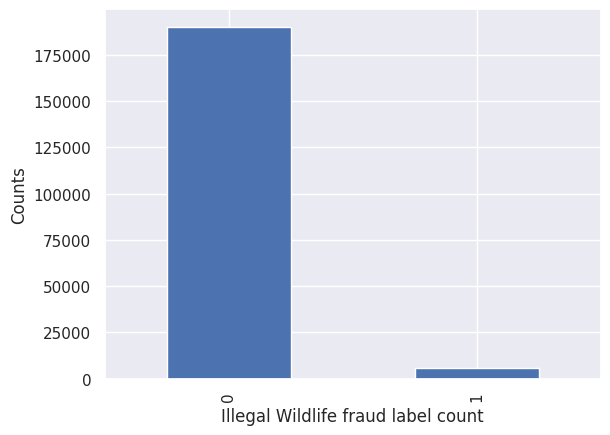

In [42]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

final_df_up_2.label.value_counts().plot(kind='bar')
plt.xlabel('Illegal Wildlife fraud label count')
plt.ylabel('Counts')

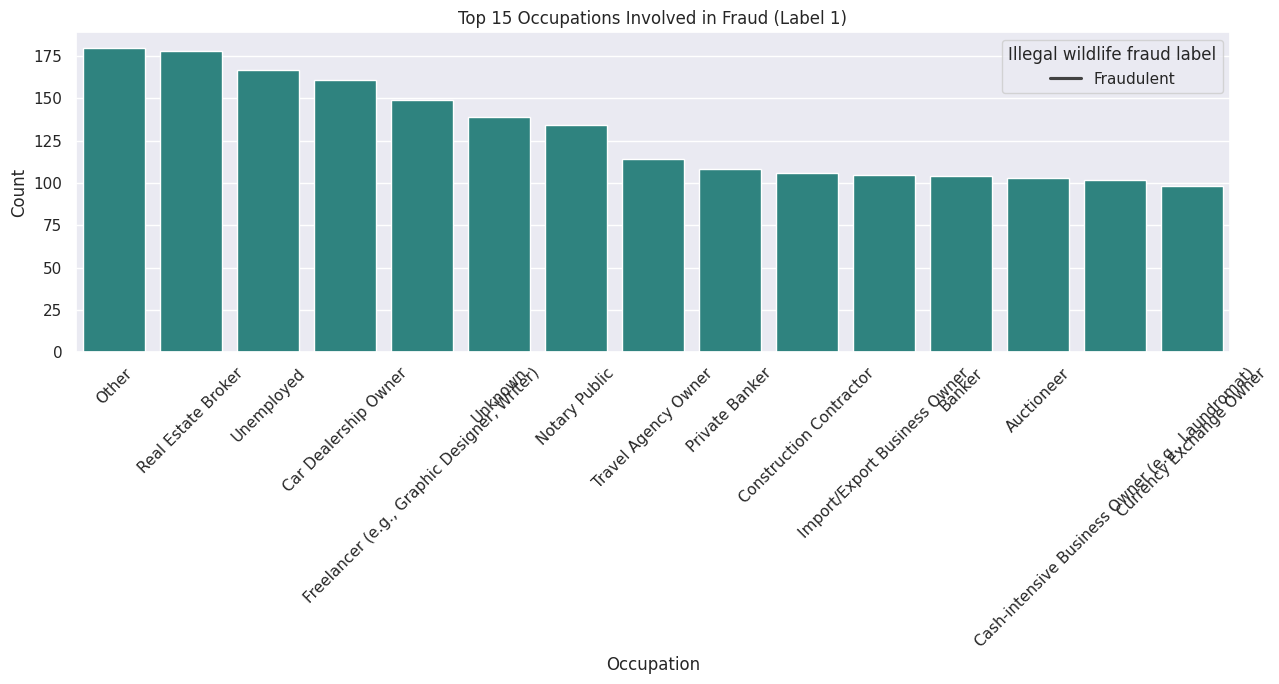

In [43]:
occupation_counts = final_df_up_2.groupby(['Occupation', 'label']).size().reset_index(name='count')

fraud_occupation_counts = occupation_counts[occupation_counts['label'] == 1].sort_values('count', ascending=False)

top_15_fraud_occupations = fraud_occupation_counts.head(15)

plt.figure(figsize=(13, 7))
sns.barplot(data=top_15_fraud_occupations, x='Occupation', y='count', hue='label', palette='viridis')
plt.title('Top 15 Occupations Involved in Fraud (Label 1)')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Illegal wildlife fraud label', labels=['Fraudulent'])
plt.tight_layout()  
plt.show()

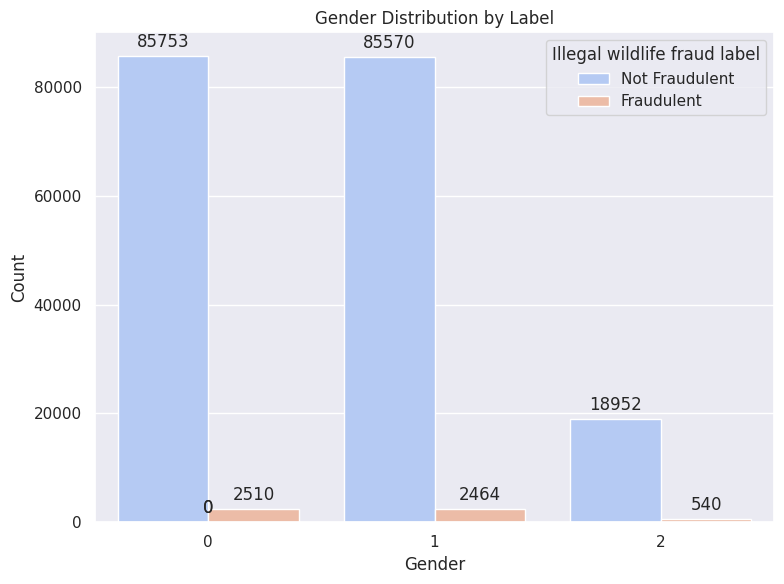

In [44]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Gender', palette='coolwarm', hue="label", data=final_df_up_2)


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title('Gender Distribution by Label')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Illegal wildlife fraud label', labels=['Not Fraudulent', 'Fraudulent'])
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
df=pd.read_csv('Task_data.csv')
df.head()

In [ ]:
df=df.drop(columns=['cust_id','id receiver','Unnamed: 0'],axis=1)
df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(14, 12))  

cmap = sns.diverging_palette(250, 10, s=85, l=40, n=9, as_cmap=True)  

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, annot_kws={"size": 10},  
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

plt.title('Correlation Heatmap', fontsize=20, fontweight='bold', color='darkred')
plt.xticks(fontsize=10, fontweight='bold', rotation=45, ha='right')  
plt.yticks(fontsize=10, fontweight='bold', rotation=0)  

plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='skyblue')

plt.title('Age Distribution with Kernel Density Estimation', fontsize=20, fontweight='bold', color='navy')
plt.xlabel('Age', fontsize=15, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

mean_age = df['Age'].mean()
plt.axvline(mean_age, color='red', linestyle='--', linewidth=2)
plt.text(mean_age+0.5, 5, f'Mean Age: {mean_age:.2f}', color='red', fontsize=12, fontweight='bold')

sns.despine()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


label_names = {1: 'Fraud', 0: 'No Fraud'}
df_task1=df.copy()
df_task1['label'] = df['label'].map(label_names)  

label_counts = df_task1['label'].value_counts()

colors = ['#FF0000' if label == 'Fraud' else '#FFE3E3' for label in label_counts.index]

labels = label_counts.index
color_map = {'Fraud': '#FF0000', 'No Fraud': '#FFE3E3'}

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=[color_map[label] for label in labels], pctdistance=1.2)

plt.title('Distribution of Labels')
plt.show()


## Model

In [22]:
X = df.drop('label',axis = 1)
y = df['label']

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [24]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=2)

In [25]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_train_encode=X_train.copy()
X_train_encode['Occupation'] = label_encoder.fit_transform(X_train['Occupation'])
X_train_encode.head()

,Gender,Occupation,Age,Tenure,emt_msg_count_s,sum_emt_trxn_s,emt_rec_ext_ratio_s,sum_wr_trxn_s,wr_rec_ext_ratio_s,sum_csh_withd,ratio_sum_csh_withd_to_total,emt_msg_count_r,sum_emt_trxn_r,emt_send_ext_ratio_r,sum_wr_trxn_r,wr_send_ext_ratio_r,sum_csh_dep,ratio_sum_csh_dep_to_total
26529,1,135,23.0,4.0,1,1056.5,0.75,0.0,0.0,0.0,0.0,0,819.0,0.0,0.0,0.0,4635.0,1.0
185095,0,22,18.0,0.0,0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
158434,1,76,43.0,2.0,0,200.5,0.50,0.0,0.0,0.0,0.0,0,386.5,0.0,0.0,0.0,0.0,0.0
125442,1,145,40.0,5.0,0,1444.5,0.50,0.0,0.0,0.0,0.0,0,2255.0,0.5,0.0,0.0,0.0,0.0
152763,2,21,22.0,0.0,0,167.5,0.00,0.0,0.0,0.0,0.0,1,155.0,0.5,0.0,0.0,0.0,0.0


In [26]:
occupation_encoding_dict={}
for i in range(0, X_train_encode.shape[0]):
  occupation_encoding_dict[X_train.iloc[i]['Occupation']]=X_train_encode.iloc[i]['Occupation']
occupation_encoding_dict

{'Makeup Artist': 135.0,
 'Bartender': 22.0,
 'Farmer': 76.0,
 'Music Producer': 145.0,
 'Barista': 21.0,
 'Real Estate Broker': 195.0,
 'Radiologist': 193.0,
 'Property Manager': 190.0,
 'Event Planner': 73.0,
 'Warehouse Worker': 246.0,
 'Construction Worker': 52.0,
 'Auctioneer': 16.0,
 'Gardener': 93.0,
 'Limnologist': 126.0,
 'Waiter/Waitress': 245.0,
 'Receptionist': 196.0,
 'Construction Contractor': 51.0,
 'Business Owner': 29.0,
 'Landscaper': 119.0,
 'Librarian Assistant': 123.0,
 'Pet Groomer': 172.0,
 'Architect': 8.0,
 'Chemist': 41.0,
 'Lawyer': 120.0,
 'Auto Dealer': 18.0,
 'Nanny': 148.0,
 'Environmental Scientist': 70.0,
 'Civil Servant': 46.0,
 'Landlord': 118.0,
 'Home Health Aide': 105.0,
 'Childcare Worker': 42.0,
 'Nightclub or Bar Owner': 151.0,
 'Florist': 86.0,
 'Enologist': 68.0,
 'International Salesperson': 114.0,
 'Cleaner': 47.0,
 'Antique Dealer': 4.0,
 'Veterinarian': 238.0,
 'Mechanic': 141.0,
 'Marine Engineer': 138.0,
 'Software Developer': 211.0,
 'L

In [27]:
X_test_encode=X_test.copy()
X_test_encode['Occupation']=X_test['Occupation'].map(occupation_encoding_dict)
X_test_encode

,Gender,Occupation,Age,Tenure,emt_msg_count_s,sum_emt_trxn_s,emt_rec_ext_ratio_s,sum_wr_trxn_s,wr_rec_ext_ratio_s,sum_csh_withd,ratio_sum_csh_withd_to_total,emt_msg_count_r,sum_emt_trxn_r,emt_send_ext_ratio_r,sum_wr_trxn_r,wr_send_ext_ratio_r,sum_csh_dep,ratio_sum_csh_dep_to_total
65644,1,222.0,41.0,16.0,0,10.0,0.000000,0.0,0.0,0.0,0.000000,0,10.0,1.00,0.0,0.0,3170.0,1.000000
41002,0,222.0,34.0,16.0,1,1103.5,0.400000,19529.0,1.0,0.0,0.000000,0,0.0,0.00,520.5,1.0,0.0,0.000000
153124,2,114.0,36.0,8.0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,6702.5,0.00,0.0,0.0,0.0,0.000000
137617,2,199.0,78.0,30.0,0,2447.0,0.500000,0.0,0.0,0.0,0.000000,0,10.0,1.00,0.0,0.0,0.0,0.000000
95539,0,189.0,41.0,8.0,0,1006.5,0.000000,0.0,0.0,5755.0,0.623848,0,139.0,1.00,0.0,0.0,3470.0,0.376152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144927,0,0.0,42.0,3.0,0,143.5,1.000000,0.0,0.0,0.0,0.000000,1,192.0,0.75,0.0,0.0,0.0,0.000000
193314,1,199.0,66.0,26.0,0,0.0,0.000000,0.0,0.0,2150.0,1.000000,0,3864.0,0.50,4876.0,0.5,0.0,0.000000
31703,0,118.0,56.0,36.0,0,1946.5,0.666667,0.0,0.0,3370.0,0.308044,0,0.0,0.00,2278.0,1.0,7570.0,0.691956
137802,1,67.0,47.0,9.0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,0.0,0.00,0.0,0.0,0.0,0.000000


In [28]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

pipeline = IMBPipeline([
    ('smote', BorderlineSMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_grid = {
    'xgb__max_depth': [6, 8, 10, 12, 14, 16, 18],  # Exploring higher values of max_depth
    'xgb__n_estimators': [100, 200, 300, 400],
    'xgb__learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='precision', cv=5, verbose=1)

grid_search.fit(X_train_encode, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

y_pred = grid_search.predict(X_test_encode)
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 8, 'xgb__n_estimators': 400}
Best CV score: 0.5967
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     38046
           1       0.63      0.50      0.56      1112

    accuracy                           0.98     39158
   macro avg       0.81      0.74      0.77     39158
weighted avg       0.98      0.98      0.98     39158

Test Accuracy: 0.9776


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

Precision: 0.6334
Recall: 0.4973
F1 Score: 0.5572


In [30]:
from sklearn import metrics
confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
#cm_display.plot()
#plt.show()
confusion_matrix1

array([[37726,   320],
       [  559,   553]])

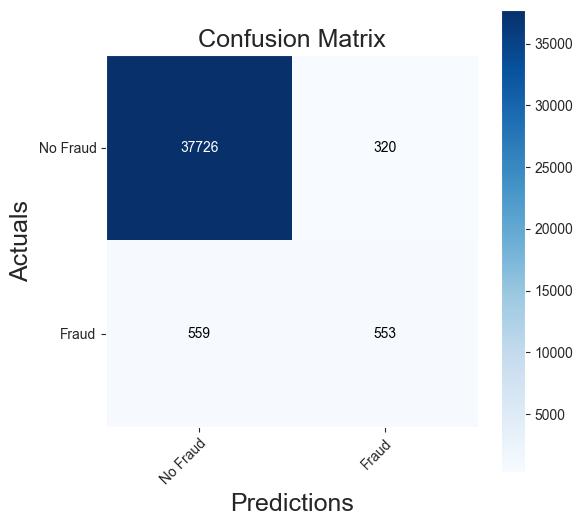

In [31]:
from mlxtend.plotting import plot_confusion_matrix
display_labels = ['No Fraud', 'Fraud']
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix1, figsize=(6, 6),colorbar=True,class_names=display_labels)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

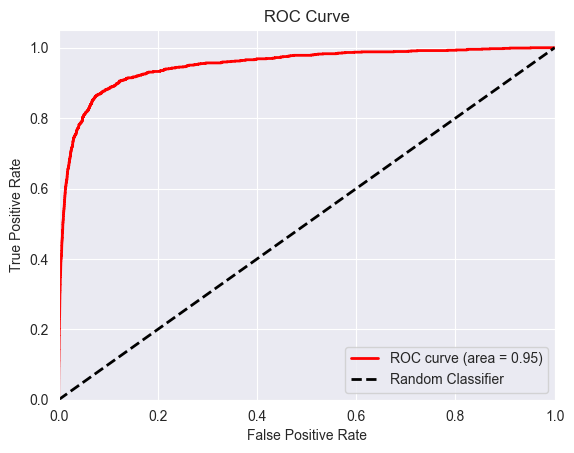

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score
y_pred_proba = grid_search.predict_proba(X_test_encode)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Feature Importance

In [37]:
X['Occupation']=X['Occupation'].map(occupation_encoding_dict)
X.head()

,Gender,Occupation,Age,Tenure,emt_msg_count_s,sum_emt_trxn_s,emt_rec_ext_ratio_s,sum_wr_trxn_s,wr_rec_ext_ratio_s,sum_csh_withd,ratio_sum_csh_withd_to_total,emt_msg_count_r,sum_emt_trxn_r,emt_send_ext_ratio_r,sum_wr_trxn_r,wr_send_ext_ratio_r,sum_csh_dep,ratio_sum_csh_dep_to_total
0,0,8.0,45.0,13.0,0,14412.0,0.428571,3971.5,0.0,0.0,0.000000,0,11484.5,0.250,0.0,0.000000,0.0,0.000000
1,1,146.0,52.0,8.0,0,0.0,0.000000,0.0,0.0,0.0,0.000000,0,84.0,1.000,0.0,0.000000,1210.0,1.000000
2,0,115.0,43.0,11.0,1,4494.0,0.200000,28263.0,1.0,0.0,0.000000,0,6538.5,0.500,22629.5,0.750000,3835.0,1.000000
3,1,161.0,35.0,17.0,0,0.0,0.000000,0.0,0.0,650.0,1.000000,0,0.0,0.000,27385.0,1.000000,0.0,0.000000
4,1,195.0,39.0,21.0,0,1147.5,0.200000,10429.0,0.5,19585.0,0.223318,0,18289.0,0.875,23895.5,0.333333,68115.0,0.776682


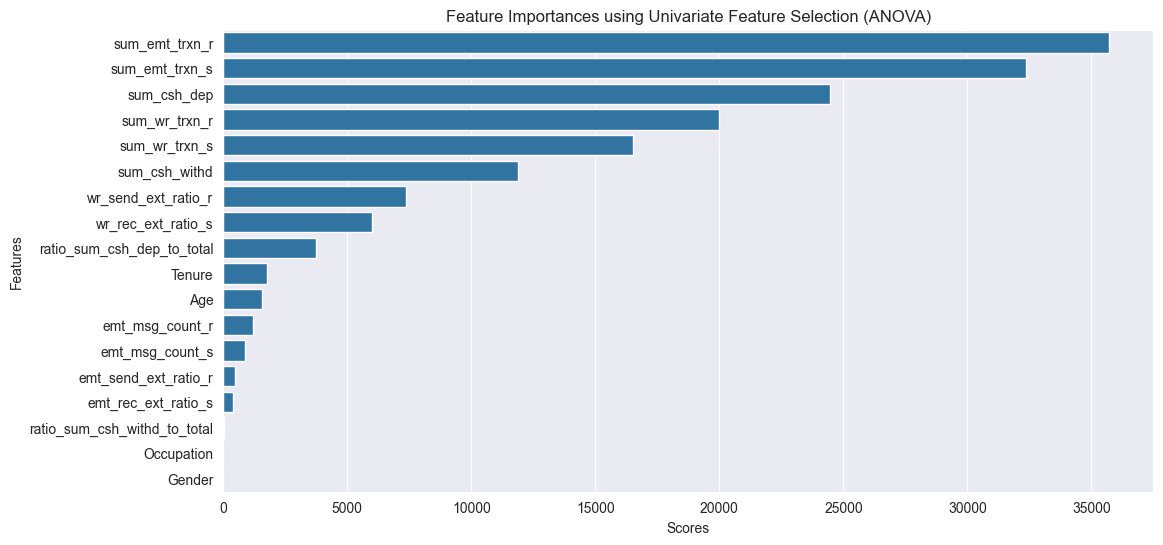

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif
best_features = SelectKBest(score_func=f_classif, k=5).fit(X, y)

scores = best_features.scores_
selected_features = X.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(X.columns)[sorted_idxs]

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_scores, y=sorted_feature_names)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection (ANOVA)')
plt.show()

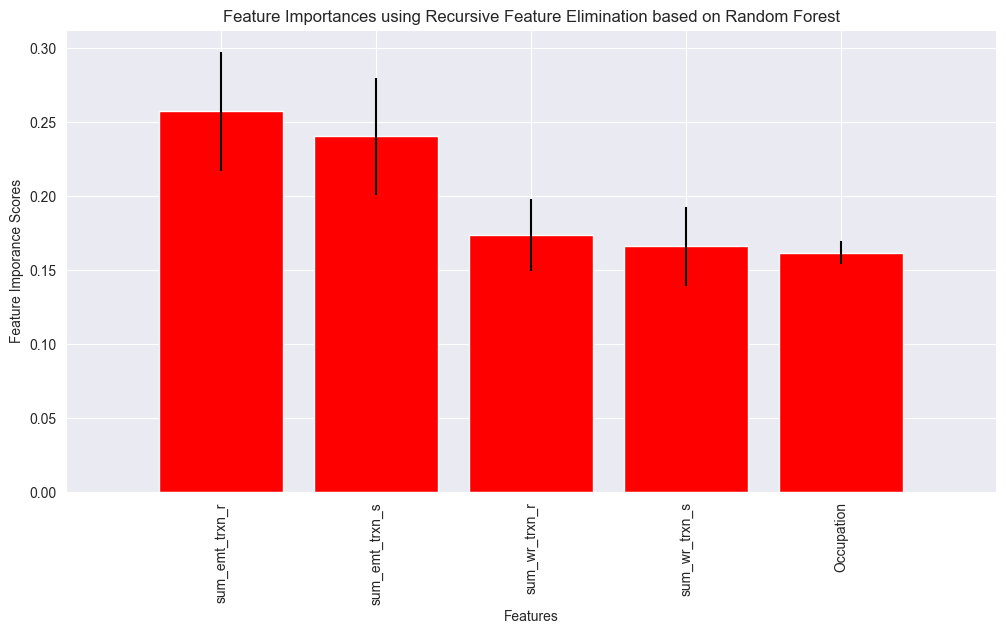

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
clf = RandomForestClassifier()

selector = RFE(clf, n_features_to_select=5)
selector = selector.fit(X, y)
X_new = selector.transform(X)

importances = selector.estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimator_.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_new.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_new.shape[1]), X.columns[selector.get_support()][indices], rotation=90)
plt.xlim([-1, X_new.shape[1]])
plt.ylabel('Feature Imporance Scores')
plt.xlabel('Features')
plt.title('Feature Importances using Recursive Feature Elimination based on Random Forest')
plt.show()

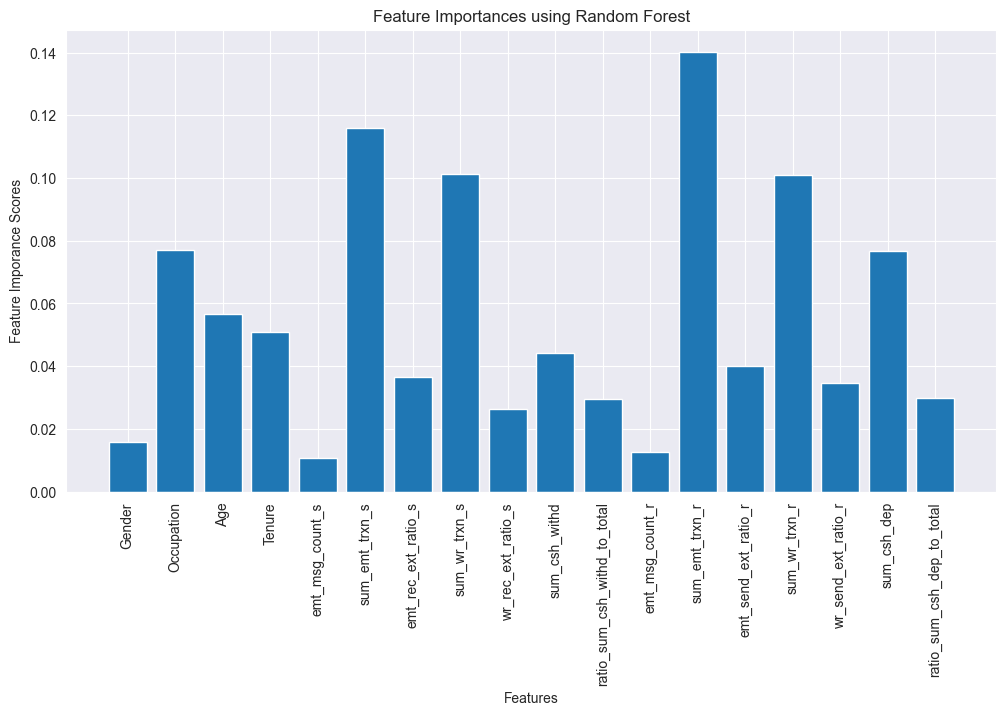

In [40]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

importances = rf_model.feature_importances_

plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.ylabel('Feature Imporance Scores')
plt.xlabel('Features')
plt.title('Feature Importances using Random Forest')
plt.show()

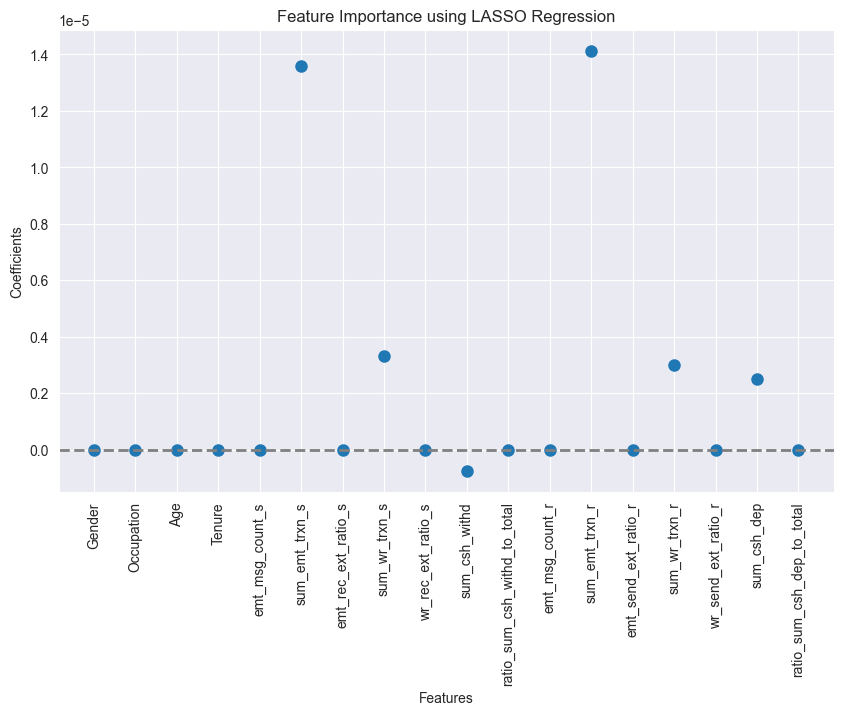

In [41]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X, y)

plt.figure(figsize=(10,6))
plt.plot(range(len(X.columns)), lasso.coef_, marker='o', markersize=8, linestyle='None')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.ylabel('Coefficients')
plt.xlabel('Features')
plt.title('Feature Importance using LASSO Regression')
plt.show()